In [1]:
# ==========================================================
# 📦 1. Install required packages
# ==========================================================
!pip install torch torchvision timm tqdm scikit-learn matplotlib pandas seaborn --quiet

In [2]:
# ==========================================================
# 📂 2. Download & Extract Dataset
# ==========================================================
# Download the CUB-200 bird species dataset from Google Drive
!gdown --fuzzy "https://drive.google.com/file/d/1qrZ-5GZBnigOjMwtkn2P9VlVeLgB5Wtz/view?usp=sharing" -O dataset.zip

# Extract the dataset quietly (-q flag) to /content/ directory
!unzip -q dataset.zip -d /content/AML_PlantDataset/

Downloading...
From (original): https://drive.google.com/uc?id=1qrZ-5GZBnigOjMwtkn2P9VlVeLgB5Wtz
From (redirected): https://drive.google.com/uc?id=1qrZ-5GZBnigOjMwtkn2P9VlVeLgB5Wtz&confirm=t&uuid=8de71de9-2d3a-41a2-a667-3173edfae293
To: /content/dataset.zip
100% 607M/607M [00:11<00:00, 53.8MB/s]


In [3]:
# ==========================================================
# 📂 3. Set Base Paths
# ==========================================================
extract_dir = "/content/AML_PlantDataset/"
train_csv = f"{extract_dir}/list/train.txt"
test_csv  = f"{extract_dir}/list/groundtruth.txt"

In [4]:
# ==========================================================
# 🌿 4. Import libraries
# ==========================================================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, top_k_accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🟢 Using device:", device)

🟢 Using device: cuda


In [5]:
# ==========================================================
# 🔍 5. Analyze Dataset Structure & Fix Label Mapping
# ==========================================================
print("\n" + "="*70)
print("🔍 DATASET ANALYSIS")
print("="*70)

# Load training data
train_data = []
with open(train_csv, 'r') as f:
    for line in f:
        parts = line.strip().split()
        img_path, class_id = parts[0], int(parts[1])
        domain = 'herbarium' if 'herbarium' in img_path.lower() else 'field'
        train_data.append({'path': img_path, 'class_id': class_id, 'domain': domain})

train_df = pd.DataFrame(train_data)

print(f"\n📊 Training Set Overview:")
print(f"   Total samples: {len(train_df)}")
print(f"   Herbarium images: {(train_df['domain'] == 'herbarium').sum()}")
print(f"   Field images: {(train_df['domain'] == 'field').sum()}")
print(f"   Unique classes: {train_df['class_id'].nunique()}")
print(f"   Class ID range: {train_df['class_id'].min()} to {train_df['class_id'].max()}")

# Load test data
test_data = []
with open(test_csv, 'r') as f:
    for line in f:
        parts = line.strip().split()
        img_path, class_id = parts[0], int(parts[1])
        test_data.append({'path': img_path, 'class_id': class_id})

test_df = pd.DataFrame(test_data)
print(f"\n📊 Test Set Overview:")
print(f"   Total samples: {len(test_df)}")
print(f"   Unique classes: {test_df['class_id'].nunique()}")
print(f"   Class ID range: {test_df['class_id'].min()} to {test_df['class_id'].max()}")

# ⚠️ CRITICAL: Create label mapping to ensure labels are 0-indexed and continuous
all_class_ids = sorted(train_df['class_id'].unique())
num_classes = len(all_class_ids)
class_id_to_idx = {class_id: idx for idx, class_id in enumerate(all_class_ids)}
idx_to_class_id = {idx: class_id for class_id, idx in class_id_to_idx.items()}

print(f"\n⚠️ LABEL MAPPING CREATED:")
print(f"   Original class IDs: {len(all_class_ids)} classes")
print(f"   Mapped to indices: 0 to {num_classes-1}")
print(f"   Example mapping: {list(class_id_to_idx.items())[:5]}")

# Load class information
with open(f"{extract_dir}/list/class_with_pairs.txt", 'r') as f:
    with_pairs = [int(x.strip()) for x in f if x.strip().isdigit()]

with open(f"{extract_dir}/list/class_without_pairs.txt", 'r') as f:
    without_pairs = [int(x.strip()) for x in f if x.strip().isdigit()]

print(f"\n📊 Class Distribution:")
print(f"   Classes WITH herbarium-field pairs: {len(with_pairs)}")
print(f"   Classes WITHOUT pairs (herbarium only): {len(without_pairs)}")


🔍 DATASET ANALYSIS

📊 Training Set Overview:
   Total samples: 4744
   Herbarium images: 3700
   Field images: 1044
   Unique classes: 100
   Class ID range: 12254 to 285398

📊 Test Set Overview:
   Total samples: 207
   Unique classes: 100
   Class ID range: 12254 to 285398

⚠️ LABEL MAPPING CREATED:
   Original class IDs: 100 classes
   Mapped to indices: 0 to 99
   Example mapping: [(np.int64(12254), 0), (np.int64(12518), 1), (np.int64(12910), 2), (np.int64(12922), 3), (np.int64(13276), 4)]

📊 Class Distribution:
   Classes WITH herbarium-field pairs: 60
   Classes WITHOUT pairs (herbarium only): 40


In [6]:
# ==========================================================
# 🌱 6. Custom Dataset class WITH LABEL MAPPING
# ==========================================================
class PlantDataset(Dataset):
    def __init__(self, txt_path, root_dir, transform=None, label_mapping=None):
        self.root_dir = root_dir
        self.transform = transform
        self.label_mapping = label_mapping
        self.data = []

        with open(txt_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                rel_path, original_label = parts[0], int(parts[1])

                # Map original label to model index
                if self.label_mapping:
                    if original_label in self.label_mapping:
                        mapped_label = self.label_mapping[original_label]
                        self.data.append((rel_path, mapped_label, original_label))
                    else:
                        print(f"⚠️ Warning: Class {original_label} not in training set, skipping")
                else:
                    self.data.append((rel_path, original_label, original_label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        rel_path, label, original_label = self.data[idx]
        img_path = os.path.join(self.root_dir, rel_path)

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"⚠️ Error loading {img_path}: {e}")
            image = Image.fromarray(np.zeros((224, 224, 3), dtype=np.uint8))

        if self.transform:
            image = self.transform(image)

        return image, label, original_label

In [7]:
# ==========================================================
# 🔧 7. Define Transforms
# ==========================================================
train_transform = transforms.Compose([
    # This single operation handles both random cropping and final resizing
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    # Standard evaluation transformation: Resize the shorter side to 256,
    # then take a center crop of 224x224 to maintain maximum context.
    # I've updated the test_transform to the more standard approach for validation.
    transforms.Resize(256),              # Resize shortest side to 256
    transforms.CenterCrop(224),          # Take center 224x224 crop
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [8]:
# ==========================================================
# 🧾 8. Load Dataset WITH LABEL MAPPING
# ==========================================================
train_dataset = PlantDataset(train_csv, extract_dir, transform=train_transform, label_mapping=class_id_to_idx)
test_dataset = PlantDataset(test_csv, extract_dir, transform=test_transform, label_mapping=class_id_to_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"\n✅ DataLoaders Ready:")
print(f"   Train samples: {len(train_dataset)}")
print(f"   Test samples: {len(test_dataset)}")
print(f"   Number of classes: {num_classes}")
print(f"   Batch size: 32")

# Verify label range
print(f"\n🔍 Verifying label range...")
sample_labels = [label for _, label, _ in train_dataset.data[:100]]
print(f"   Sample labels: min={min(sample_labels)}, max={max(sample_labels)}")
print(f"   Expected range: 0 to {num_classes-1}")
assert max(sample_labels) < num_classes, f"Label {max(sample_labels)} exceeds num_classes {num_classes}!"
print(f"   ✅ Label range verified!")


✅ DataLoaders Ready:
   Train samples: 4744
   Test samples: 207
   Number of classes: 100
   Batch size: 32

🔍 Verifying label range...
   Sample labels: min=1, max=20
   Expected range: 0 to 99
   ✅ Label range verified!


In [16]:
# ==========================================================
# 🏗️ 9. Build ConvNeXt-Base Model & Configure Head
# ==========================================================
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
# NOTE: Ensure all necessary libraries (timm, torch, nn, optim, tqdm) are imported once at the start

# --- Define Hyperparameters ---
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
CONVNEXT_MODEL_NAME = 'convnext_base'
DROPOUT_RATE = 0.3  # For the final classifier head

# Assuming num_classes and device are defined

print(f"\n📊 Building model: {CONVNEXT_MODEL_NAME} with {num_classes} classes")

# 1. Create the ConvNeXt-Base model
model = timm.create_model(CONVNEXT_MODEL_NAME, pretrained=True, num_classes=num_classes)

# --- Parameter Freezing ---
print("\n🔒 Configuring partial fine-tuning...")

# ConvNeXt structure: stages.0, stages.1, stages.2, stages.3, head
# We'll freeze the first two stages (stages.0 and stages.1)
for name, param in model.named_parameters():
    # Freeze the initial two stages/blocks
    if 'stages.0' in name or 'stages.1' in name:
        param.requires_grad = False
    else:
        # Unfreeze the remaining blocks, normalization, and the final classification head
        param.requires_grad = True

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📊 Model Parameters:")
print(f"   Total: {total_params:,}")
print(f"   Trainable: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")

model = model.to(device)


# --- Dropout Insertion (FIXED) ---
print(f"\n🧠 Modifying ConvNeXt head to insert Dropout (p={DROPOUT_RATE})...")

# 1. Get the original fully connected (FC) layer from the head
# This layer is correctly accessed via model.head.fc in the standard timm ConvNeXt structure.
original_fc = model.head.fc

# 2. Get the number of input features (should be 1024 for ConvNeXt-Base)
num_features = original_fc.in_features

# 3. Create a new Sequential module containing the Dropout and the new Linear layer
new_fc_with_dropout = nn.Sequential(
    nn.Dropout(p=DROPOUT_RATE),
    nn.Linear(num_features, num_classes)
)

# 4. Replace the original FC layer with the new sequential module
# This ensures the crucial LayerNorm and Pooling components of model.head remain intact.
model.head.fc = new_fc_with_dropout
model = model.to(device)

print(f"✅ Model fully configured: ConvNeXt-Base built, partially frozen, and head replaced with Dropout.")


📊 Building model: convnext_base with 100 classes

🔒 Configuring partial fine-tuning...

📊 Model Parameters:
   Total: 87,668,964
   Trainable: 85,504,484 (97.5%)

🧠 Modifying ConvNeXt head to insert Dropout (p=0.3)...
✅ Model fully configured: ConvNeXt-Base built, partially frozen, and head replaced with Dropout.


In [17]:
# ==========================================================
# 🎯 10. Training Configuration
# ==========================================================
criterion = nn.CrossEntropyLoss()

print("\n⚙️ Defining Optimizer with AdamW and Weight Decay...")

# 1. Separate parameters into groups to exclude weight decay from bias and BN layers
no_decay = ["bias", "LayerNorm.weight", "bn.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay) and p.requires_grad],
        "weight_decay": WEIGHT_DECAY,
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay) and p.requires_grad],
        "weight_decay": 0.0,
    },
]

# 2. Use AdamW, which implements L2 regularization correctly
optimizer = optim.AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

num_epochs = 20


⚙️ Defining Optimizer with AdamW and Weight Decay...


In [18]:
# ==========================================================
# 🚀 11. Training Loop
# ==========================================================
train_losses = []
train_accuracies = []

print("\n" + "="*70)
print("🚀 STARTING TRAINING")
print("="*70)

best_train_acc = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch_data in progress_bar:
        # Unpack: image, mapped_label, original_label
        images, labels, original_labels = batch_data
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"   Loss: {epoch_loss:.4f}")
    print(f"   Accuracy: {epoch_acc:.2f}%")

    if epoch_acc > best_train_acc:
        best_train_acc = epoch_acc
        print(f"   ⭐ New best training accuracy!")

    scheduler.step(epoch_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"   Learning Rate: {current_lr:.6f}")

print("\n✅ Training Complete!")
print(f"🏆 Best Training Accuracy: {best_train_acc:.2f}%")


🚀 STARTING TRAINING


Epoch 1/20: 100%|██████████| 149/149 [02:47<00:00,  1.12s/it, loss=1.9168, acc=26.85%]



📊 Epoch 1 Summary:
   Loss: 3.4398
   Accuracy: 26.85%
   ⭐ New best training accuracy!
   Learning Rate: 0.000100


Epoch 2/20: 100%|██████████| 149/149 [02:40<00:00,  1.07s/it, loss=1.3742, acc=66.48%]



📊 Epoch 2 Summary:
   Loss: 1.5060
   Accuracy: 66.48%
   ⭐ New best training accuracy!
   Learning Rate: 0.000100


Epoch 3/20: 100%|██████████| 149/149 [02:39<00:00,  1.07s/it, loss=0.4014, acc=84.25%]



📊 Epoch 3 Summary:
   Loss: 0.7331
   Accuracy: 84.25%
   ⭐ New best training accuracy!
   Learning Rate: 0.000100


Epoch 4/20: 100%|██████████| 149/149 [02:39<00:00,  1.07s/it, loss=0.6690, acc=92.07%]



📊 Epoch 4 Summary:
   Loss: 0.3896
   Accuracy: 92.07%
   ⭐ New best training accuracy!
   Learning Rate: 0.000100


Epoch 5/20: 100%|██████████| 149/149 [02:40<00:00,  1.07s/it, loss=0.0299, acc=96.92%]



📊 Epoch 5 Summary:
   Loss: 0.1923
   Accuracy: 96.92%
   ⭐ New best training accuracy!
   Learning Rate: 0.000100


Epoch 6/20: 100%|██████████| 149/149 [02:39<00:00,  1.07s/it, loss=0.0342, acc=98.78%]



📊 Epoch 6 Summary:
   Loss: 0.0947
   Accuracy: 98.78%
   ⭐ New best training accuracy!
   Learning Rate: 0.000100


Epoch 7/20: 100%|██████████| 149/149 [02:39<00:00,  1.07s/it, loss=0.0271, acc=99.52%]



📊 Epoch 7 Summary:
   Loss: 0.0554
   Accuracy: 99.52%
   ⭐ New best training accuracy!
   Learning Rate: 0.000100


Epoch 8/20: 100%|██████████| 149/149 [02:40<00:00,  1.07s/it, loss=0.0129, acc=99.79%]



📊 Epoch 8 Summary:
   Loss: 0.0328
   Accuracy: 99.79%
   ⭐ New best training accuracy!
   Learning Rate: 0.000100


Epoch 9/20: 100%|██████████| 149/149 [02:41<00:00,  1.08s/it, loss=0.0064, acc=99.92%]



📊 Epoch 9 Summary:
   Loss: 0.0169
   Accuracy: 99.92%
   ⭐ New best training accuracy!
   Learning Rate: 0.000100


Epoch 10/20: 100%|██████████| 149/149 [02:39<00:00,  1.07s/it, loss=0.0058, acc=100.00%]



📊 Epoch 10 Summary:
   Loss: 0.0143
   Accuracy: 100.00%
   ⭐ New best training accuracy!
   Learning Rate: 0.000100


Epoch 11/20: 100%|██████████| 149/149 [02:40<00:00,  1.08s/it, loss=0.0068, acc=99.81%]



📊 Epoch 11 Summary:
   Loss: 0.0193
   Accuracy: 99.81%
   Learning Rate: 0.000100


Epoch 12/20: 100%|██████████| 149/149 [02:39<00:00,  1.07s/it, loss=0.0051, acc=99.87%]



📊 Epoch 12 Summary:
   Loss: 0.0131
   Accuracy: 99.87%
   Learning Rate: 0.000100


Epoch 13/20: 100%|██████████| 149/149 [02:39<00:00,  1.07s/it, loss=0.0118, acc=100.00%]



📊 Epoch 13 Summary:
   Loss: 0.0056
   Accuracy: 100.00%
   Learning Rate: 0.000100


Epoch 14/20: 100%|██████████| 149/149 [02:40<00:00,  1.07s/it, loss=0.0118, acc=100.00%]



📊 Epoch 14 Summary:
   Loss: 0.0042
   Accuracy: 100.00%
   Learning Rate: 0.000100


Epoch 15/20: 100%|██████████| 149/149 [02:39<00:00,  1.07s/it, loss=0.0832, acc=98.99%]



📊 Epoch 15 Summary:
   Loss: 0.0463
   Accuracy: 98.99%
   Learning Rate: 0.000100


Epoch 16/20: 100%|██████████| 149/149 [02:39<00:00,  1.07s/it, loss=0.0379, acc=97.55%]



📊 Epoch 16 Summary:
   Loss: 0.1026
   Accuracy: 97.55%
   Learning Rate: 0.000100


Epoch 17/20: 100%|██████████| 149/149 [02:39<00:00,  1.07s/it, loss=0.7833, acc=98.67%]



📊 Epoch 17 Summary:
   Loss: 0.0629
   Accuracy: 98.67%
   Learning Rate: 0.000100


Epoch 18/20: 100%|██████████| 149/149 [02:39<00:00,  1.07s/it, loss=0.0032, acc=97.85%]



📊 Epoch 18 Summary:
   Loss: 0.0891
   Accuracy: 97.85%
   Learning Rate: 0.000050


Epoch 19/20: 100%|██████████| 149/149 [02:39<00:00,  1.07s/it, loss=0.0104, acc=99.75%]



📊 Epoch 19 Summary:
   Loss: 0.0143
   Accuracy: 99.75%
   Learning Rate: 0.000050


Epoch 20/20: 100%|██████████| 149/149 [02:39<00:00,  1.07s/it, loss=0.0041, acc=100.00%]


📊 Epoch 20 Summary:
   Loss: 0.0047
   Accuracy: 100.00%
   Learning Rate: 0.000050

✅ Training Complete!
🏆 Best Training Accuracy: 100.00%


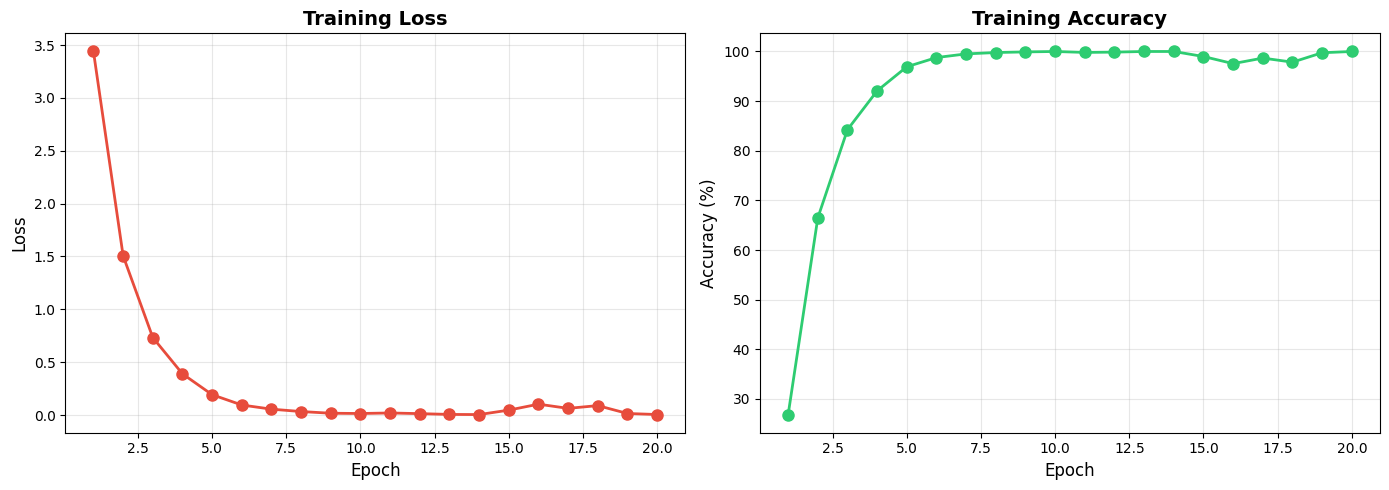

In [19]:
# ==========================================================
# 📈 12. Plot Training History
# ==========================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(range(1, num_epochs+1), train_losses, marker='o', color='#e74c3c', linewidth=2, markersize=8)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(range(1, num_epochs+1), train_accuracies, marker='o', color='#2ecc71', linewidth=2, markersize=8)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training Accuracy', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# ==========================================================
# 🧪 13. Model Evaluation (FIXED)
# ==========================================================
print("\n" + "="*70)
print("🧪 EVALUATING MODEL ON TEST SET")
print("="*70)

model.eval()
test_labels = []  # Original class IDs for evaluation
pred_top1 = []    # Predicted original class IDs
pred_probs = []   # Prediction probabilities

with torch.no_grad():
    for batch_data in tqdm(test_loader, desc="Testing"):
        images, labels, original_labels = batch_data
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted_idx = torch.max(outputs, 1)

        # Convert predicted indices back to original class IDs
        predicted_class_ids = [idx_to_class_id[idx.item()] for idx in predicted_idx]

        test_labels.extend(original_labels.cpu().numpy())
        pred_top1.extend(predicted_class_ids)
        pred_probs.extend(probs.cpu().numpy())

test_labels = np.array(test_labels)
pred_top1 = np.array(pred_top1)
pred_probs = np.array(pred_probs)

# Calculate accuracies
top1_acc = accuracy_score(test_labels, pred_top1)

# For top-5, we need to map back the indices
top5_correct = 0
for i, (true_label, prob_dist) in enumerate(zip(test_labels, pred_probs)):
    top5_indices = np.argsort(prob_dist)[-5:][::-1]
    top5_class_ids = [idx_to_class_id[idx] for idx in top5_indices]
    if true_label in top5_class_ids:
        top5_correct += 1

top5_acc = top5_correct / len(test_labels)

print(f"\n🎯 Test Results (Field Images Only):")
print(f"   Top-1 Accuracy: {top1_acc*100:.2f}%")
print(f"   Top-5 Accuracy: {top5_acc*100:.2f}%")


🧪 EVALUATING MODEL ON TEST SET


Testing: 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]


🎯 Test Results (Field Images Only):
   Top-1 Accuracy: 62.32%
   Top-5 Accuracy: 76.81%


In [21]:
# ==========================================================
# 📊 COMPREHENSIVE EVALUATION WITH PAIRS ANALYSIS
# ==========================================================
import pandas as pd
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, balanced_accuracy_score,
                            top_k_accuracy_score, classification_report,
                            confusion_matrix)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("="*70)
print("📊 COMPREHENSIVE EVALUATION REPORT")
print("="*70)

📊 COMPREHENSIVE EVALUATION REPORT


In [22]:
# ==========================================================
# 🔧 1. Load Class Information
# ==========================================================
def load_ids(file_path):
    with open(file_path, 'r') as f:
        return [int(x.strip()) for x in f if x.strip().isdigit()]

with_ids = load_ids(f"{extract_dir}/list/class_with_pairs.txt")
without_ids = load_ids(f"{extract_dir}/list/class_without_pairs.txt")

print(f"\n🔍 Class Distribution:")
print(f"  With-pairs classes: {len(with_ids)}")
print(f"  Without-pairs classes: {len(without_ids)}")
print(f"  Total classes: {len(with_ids) + len(without_ids)}")

# ==========================================================
# 🔍 2. Diagnostic Information
# ==========================================================
test_label_set = set(test_labels)
with_overlap = len(set(with_ids) & test_label_set)
without_overlap = len(set(without_ids) & test_label_set)

print(f"\n📊 Test Set Coverage:")
print(f"  With-pairs classes in test: {with_overlap}/{len(with_ids)}")
print(f"  Without-pairs classes in test: {without_overlap}/{len(without_ids)}")
print(f"  Total unique test classes: {len(test_label_set)}")


🔍 Class Distribution:
  With-pairs classes: 60
  Without-pairs classes: 40
  Total classes: 100

📊 Test Set Coverage:
  With-pairs classes in test: 60/60
  Without-pairs classes in test: 40/40
  Total unique test classes: 100


In [23]:
# ==========================================================
# 🌍 3. OVERALL METRICS
# ==========================================================
print("\n" + "="*70)
print("🌍 OVERALL METRICS (All Test Samples)")
print("="*70)

# Create DataFrame for analysis
df = pd.DataFrame({'true': test_labels, 'pred': pred_top1})

# Overall accuracy
print(f"🌿 Top-1 Accuracy: {top1_acc*100:.2f}%")
print(f"🌺 Top-5 Accuracy: {top5_acc*100:.2f}%")
print(f"📝 Total Test Samples: {len(test_labels)}")

# Additional overall metrics
precision_overall = precision_score(test_labels, pred_top1, average='weighted', zero_division=0)
recall_overall = recall_score(test_labels, pred_top1, average='weighted', zero_division=0)
f1_overall = f1_score(test_labels, pred_top1, average='weighted', zero_division=0)
balanced_acc_overall = balanced_accuracy_score(test_labels, pred_top1)

print(f"\n🔬 Additional Overall Metrics:")
print(f"  Precision (weighted): {precision_overall*100:.2f}%")
print(f"  Recall (weighted):    {recall_overall*100:.2f}%")
print(f"  F1-Score (weighted):  {f1_overall*100:.2f}%")
print(f"  Balanced Accuracy:    {balanced_acc_overall*100:.2f}%")


🌍 OVERALL METRICS (All Test Samples)
🌿 Top-1 Accuracy: 62.32%
🌺 Top-5 Accuracy: 76.81%
📝 Total Test Samples: 207

🔬 Additional Overall Metrics:
  Precision (weighted): 54.03%
  Recall (weighted):    62.32%
  F1-Score (weighted):  54.61%
  Balanced Accuracy:    51.17%


In [24]:
# ==========================================================
# ✅ 4. WITH-PAIRS SUBSET EVALUATION
# ==========================================================
print("\n" + "="*70)
print("✅ WITH-PAIRS SUBSET (Classes with both herbarium & field training)")
print("="*70)

subset_with = df[df['true'].isin(with_ids)]

if len(subset_with) > 0:
    # Top-1 accuracy
    acc_with_top1 = accuracy_score(subset_with['true'], subset_with['pred'])

    # Top-5 accuracy calculation
    with_indices = df['true'].isin(with_ids)
    with_test_labels = test_labels[with_indices]
    with_pred_probs = pred_probs[with_indices]

    # Map to with_ids space for proper top-5 calculation
    with_label_set = sorted(set(with_ids) & test_label_set)
    with_label_to_idx = {label: idx for idx, label in enumerate(with_label_set)}

    # Remap labels
    with_test_remapped = np.array([with_label_to_idx[label] for label in with_test_labels])

    # Extract probabilities for with-pairs classes only
    with_prob_indices = [class_id_to_idx[label] for label in with_label_set if label in class_id_to_idx]
    with_pred_probs_subset = with_pred_probs[:, with_prob_indices]

    acc_with_top5 = top_k_accuracy_score(with_test_remapped, with_pred_probs_subset,
                                         k=min(5, len(with_label_set)))

    # Additional metrics
    precision_with = precision_score(subset_with['true'], subset_with['pred'],
                                    average='weighted', zero_division=0)
    recall_with = recall_score(subset_with['true'], subset_with['pred'],
                              average='weighted', zero_division=0)
    f1_with = f1_score(subset_with['true'], subset_with['pred'],
                       average='weighted', zero_division=0)
    balanced_acc_with = balanced_accuracy_score(subset_with['true'], subset_with['pred'])

    print(f"🌿 Top-1 Accuracy: {acc_with_top1*100:.2f}%")
    print(f"🌺 Top-5 Accuracy: {acc_with_top5*100:.2f}%")
    print(f"📝 Test Samples: {len(subset_with)}")
    print(f"📚 Number of Classes: {len(set(subset_with['true']))}")

    print(f"\n🔬 Additional Metrics:")
    print(f"  Precision (weighted): {precision_with*100:.2f}%")
    print(f"  Recall (weighted):    {recall_with*100:.2f}%")
    print(f"  F1-Score (weighted):  {f1_with*100:.2f}%")
    print(f"  Balanced Accuracy:    {balanced_acc_with*100:.2f}%")
else:
    print("⚠️ No test samples found for With-Pairs classes")
    acc_with_top1 = acc_with_top5 = 0
    precision_with = recall_with = f1_with = balanced_acc_with = 0


✅ WITH-PAIRS SUBSET (Classes with both herbarium & field training)
🌿 Top-1 Accuracy: 83.01%
🌺 Top-5 Accuracy: 96.08%
📝 Test Samples: 153
📚 Number of Classes: 60

🔬 Additional Metrics:
  Precision (weighted): 87.33%
  Recall (weighted):    83.01%
  F1-Score (weighted):  82.23%
  Balanced Accuracy:    82.78%


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [25]:
# ==========================================================
# ❌ 5. WITHOUT-PAIRS SUBSET EVALUATION
# ==========================================================
print("\n" + "="*70)
print("❌ WITHOUT-PAIRS SUBSET (Classes with only herbarium training)")
print("="*70)

subset_without = df[df['true'].isin(without_ids)]

if len(subset_without) > 0:
    # Top-1 accuracy
    acc_without_top1 = accuracy_score(subset_without['true'], subset_without['pred'])

    # Top-5 accuracy calculation
    without_indices = df['true'].isin(without_ids)
    without_test_labels = test_labels[without_indices]
    without_pred_probs = pred_probs[without_indices]

    # Map to without_ids space
    without_label_set = sorted(set(without_ids) & test_label_set)
    without_label_to_idx = {label: idx for idx, label in enumerate(without_label_set)}

    # Remap labels
    without_test_remapped = np.array([without_label_to_idx[label] for label in without_test_labels])

    # Extract probabilities for without-pairs classes
    without_prob_indices = [class_id_to_idx[label] for label in without_label_set if label in class_id_to_idx]
    without_pred_probs_subset = without_pred_probs[:, without_prob_indices]

    acc_without_top5 = top_k_accuracy_score(without_test_remapped, without_pred_probs_subset,
                                           k=min(5, len(without_label_set)))

    # Additional metrics
    precision_without = precision_score(subset_without['true'], subset_without['pred'],
                                       average='weighted', zero_division=0)
    recall_without = recall_score(subset_without['true'], subset_without['pred'],
                                 average='weighted', zero_division=0)
    f1_without = f1_score(subset_without['true'], subset_without['pred'],
                         average='weighted', zero_division=0)
    balanced_acc_without = balanced_accuracy_score(subset_without['true'], subset_without['pred'])

    print(f"🌿 Top-1 Accuracy: {acc_without_top1*100:.2f}%")
    print(f"🌺 Top-5 Accuracy: {acc_without_top5*100:.2f}%")
    print(f"📝 Test Samples: {len(subset_without)}")
    print(f"📚 Number of Classes: {len(set(subset_without['true']))}")

    print(f"\n🔬 Additional Metrics:")
    print(f"  Precision (weighted): {precision_without*100:.2f}%")
    print(f"  Recall (weighted):    {recall_without*100:.2f}%")
    print(f"  F1-Score (weighted):  {f1_without*100:.2f}%")
    print(f"  Balanced Accuracy:    {balanced_acc_without*100:.2f}%")
else:
    print("⚠️ No test samples found for Without-Pairs classes")
    print("💡 This likely means the test set only contains 'with-pairs' species")
    acc_without_top1 = acc_without_top5 = 0
    precision_without = recall_without = f1_without = balanced_acc_without = 0


❌ WITHOUT-PAIRS SUBSET (Classes with only herbarium training)
🌿 Top-1 Accuracy: 3.70%
🌺 Top-5 Accuracy: 57.41%
📝 Test Samples: 54
📚 Number of Classes: 40

🔬 Additional Metrics:
  Precision (weighted): 5.56%
  Recall (weighted):    3.70%
  F1-Score (weighted):  4.32%
  Balanced Accuracy:    3.75%


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [26]:
# ==========================================================
# 📈 6. SUMMARY COMPARISON
# ==========================================================
print("\n" + "="*70)
print("📈 SUMMARY COMPARISON")
print("="*70)
print(f"{'Metric':<30} {'Overall':<15} {'With-Pairs':<15} {'Without-Pairs':<15}")
print("-"*70)
print(f"{'Top-1 Accuracy':<30} {top1_acc*100:>6.2f}%        {acc_with_top1*100:>6.2f}%        {acc_without_top1*100:>6.2f}%")
print(f"{'Top-5 Accuracy':<30} {top5_acc*100:>6.2f}%        {acc_with_top5*100:>6.2f}%        {acc_without_top5*100:>6.2f}%")
print(f"{'Precision':<30} {precision_overall*100:>6.2f}%        {precision_with*100:>6.2f}%        {precision_without*100:>6.2f}%")
print(f"{'Recall':<30} {recall_overall*100:>6.2f}%        {recall_with*100:>6.2f}%        {recall_without*100:>6.2f}%")
print(f"{'F1-Score':<30} {f1_overall*100:>6.2f}%        {f1_with*100:>6.2f}%        {f1_without*100:>6.2f}%")
print(f"{'Balanced Accuracy':<30} {balanced_acc_overall*100:>6.2f}%        {balanced_acc_with*100:>6.2f}%        {balanced_acc_without*100:>6.2f}%")
print(f"{'Sample Count':<30} {len(test_labels):>6}         {len(subset_with):>6}         {len(subset_without):>6}")
print("="*70)


📈 SUMMARY COMPARISON
Metric                         Overall         With-Pairs      Without-Pairs  
----------------------------------------------------------------------
Top-1 Accuracy                  62.32%         83.01%          3.70%
Top-5 Accuracy                  76.81%         96.08%         57.41%
Precision                       54.03%         87.33%          5.56%
Recall                          62.32%         83.01%          3.70%
F1-Score                        54.61%         82.23%          4.32%
Balanced Accuracy               51.17%         82.78%          3.75%
Sample Count                      207            153             54


In [27]:
# ==========================================================
# 🎯 7. PER-CLASS PERFORMANCE
# ==========================================================
print("\n" + "="*70)
print("🎯 PER-CLASS PERFORMANCE")
print("="*70)

class_results = []
for class_id in sorted(test_label_set):
    mask = df['true'] == class_id
    if mask.sum() > 0:
        class_acc = (df[mask]['true'] == df[mask]['pred']).mean()
        is_with_pair = class_id in with_ids
        class_results.append({
            'class_id': class_id,
            'accuracy': class_acc,
            'samples': mask.sum(),
            'pair_type': 'With-Pairs' if is_with_pair else 'Without-Pairs'
        })

class_df = pd.DataFrame(class_results).sort_values('accuracy', ascending=False)

print("\n🏆 TOP 10 BEST PERFORMING CLASSES:")
print(class_df.head(10).to_string(index=False))

print("\n⚠️ TOP 10 WORST PERFORMING CLASSES:")
print(class_df.tail(10).to_string(index=False))

print("\n📊 Performance Distribution:")
print(f"  Classes with >80% accuracy: {(class_df['accuracy'] > 0.8).sum()}")
print(f"  Classes with 50-80% accuracy: {((class_df['accuracy'] >= 0.5) & (class_df['accuracy'] <= 0.8)).sum()}")
print(f"  Classes with <50% accuracy: {(class_df['accuracy'] < 0.5).sum()}")
print(f"  Classes with 0% accuracy: {(class_df['accuracy'] == 0).sum()}")


🎯 PER-CLASS PERFORMANCE

🏆 TOP 10 BEST PERFORMING CLASSES:
 class_id  accuracy  samples  pair_type
    12922       1.0        2 With-Pairs
    12910       1.0        3 With-Pairs
    14353       1.0        2 With-Pairs
    13370       1.0        3 With-Pairs
   127097       1.0        2 With-Pairs
   121836       1.0        2 With-Pairs
    15318       1.0        2 With-Pairs
    19489       1.0        3 With-Pairs
    19165       1.0        3 With-Pairs
    29686       1.0        3 With-Pairs

⚠️ TOP 10 WORST PERFORMING CLASSES:
 class_id  accuracy  samples     pair_type
   145020       0.0        1 Without-Pairs
   148220       0.0        1 Without-Pairs
   140367       0.0        2 Without-Pairs
   169293       0.0        3 Without-Pairs
   173914       0.0        3 Without-Pairs
   159518       0.0        1 Without-Pairs
   159434       0.0        1 Without-Pairs
   159516       0.0        1 Without-Pairs
   160570       0.0        2 Without-Pairs
   177730       0.0        3 With


📊 GENERATING VISUALIZATIONS


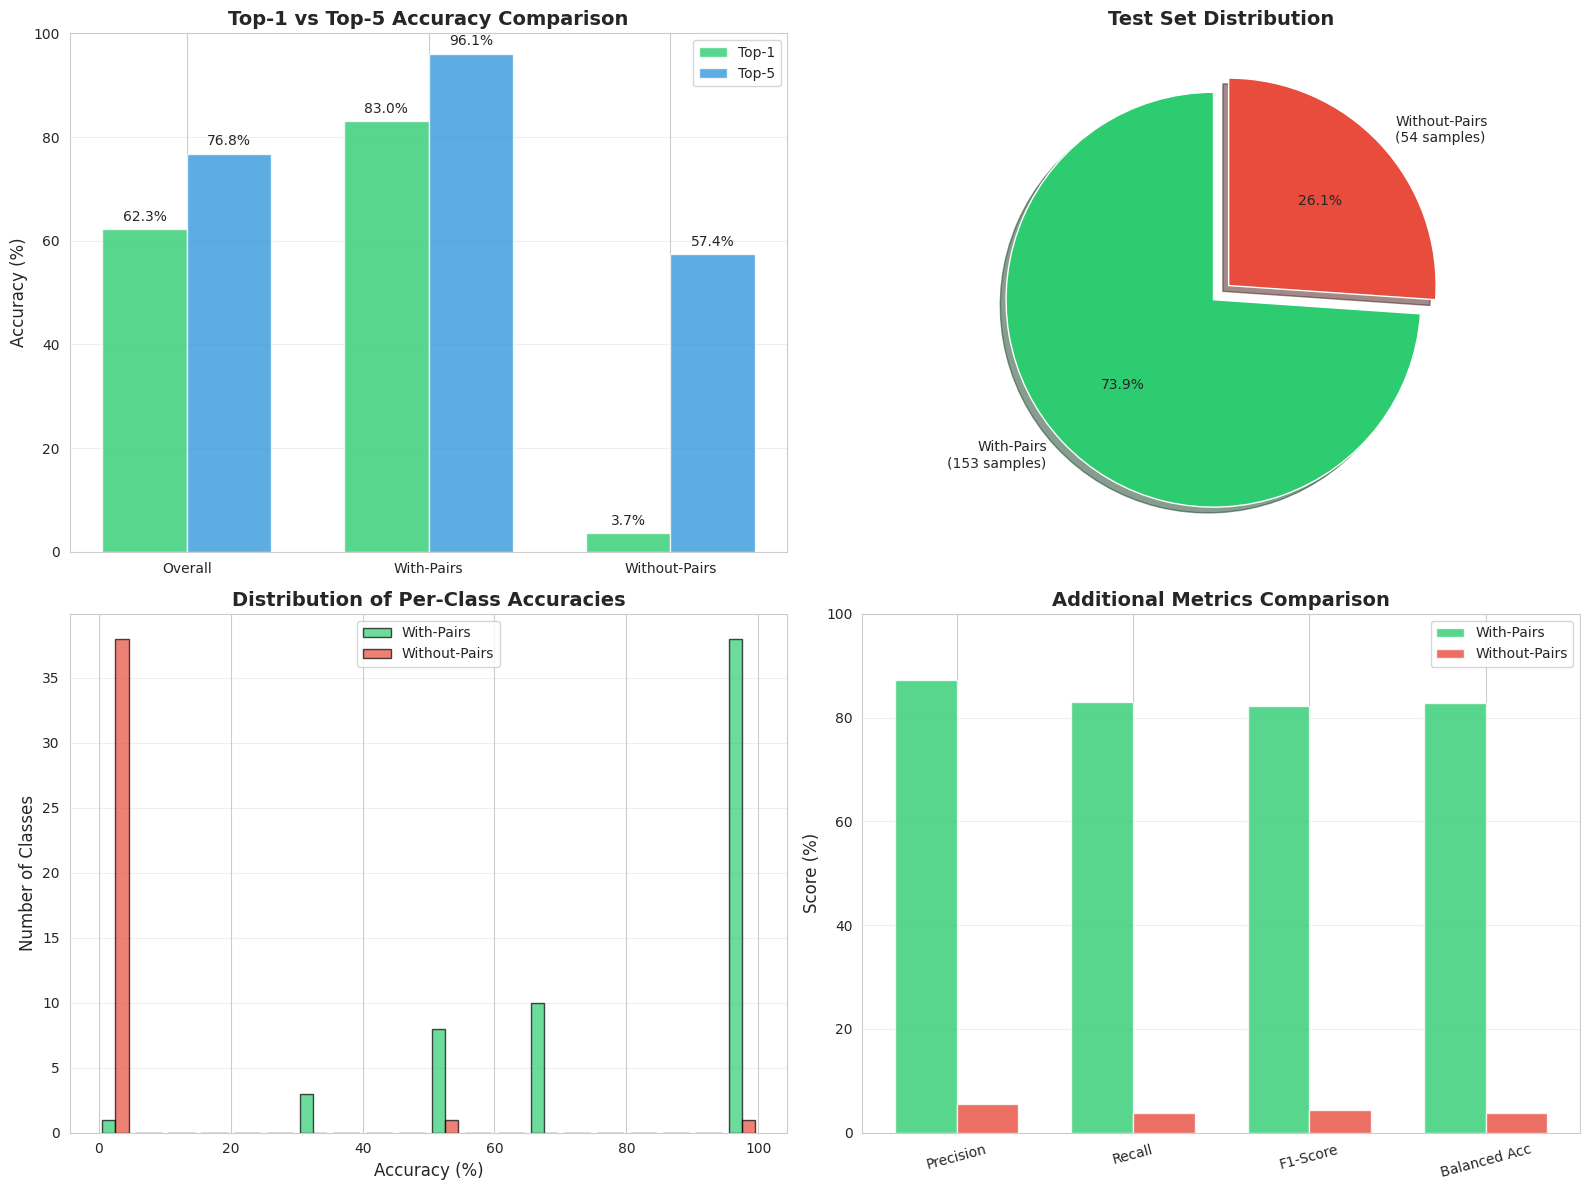

In [28]:
# ==========================================================
# 📈 8. VISUALIZATIONS
# ==========================================================
print("\n" + "="*70)
print("📊 GENERATING VISUALIZATIONS")
print("="*70)

sns.set_style("whitegrid")

# 1. Accuracy Comparison Bar Chart
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Subplot 1: Top-1 vs Top-5 comparison
metrics = ['Overall', 'With-Pairs', 'Without-Pairs']
top1_scores = [top1_acc*100, acc_with_top1*100, acc_without_top1*100]
top5_scores = [top5_acc*100, acc_with_top5*100, acc_without_top5*100]

x = np.arange(len(metrics))
width = 0.35

axes[0, 0].bar(x - width/2, top1_scores, width, label='Top-1', color='#2ecc71', alpha=0.8)
axes[0, 0].bar(x + width/2, top5_scores, width, label='Top-5', color='#3498db', alpha=0.8)
axes[0, 0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 0].set_title('Top-1 vs Top-5 Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].set_ylim([0, 100])

for i, (v1, v5) in enumerate(zip(top1_scores, top5_scores)):
    axes[0, 0].text(i - width/2, v1 + 1, f'{v1:.1f}%', ha='center', va='bottom', fontsize=10)
    axes[0, 0].text(i + width/2, v5 + 1, f'{v5:.1f}%', ha='center', va='bottom', fontsize=10)

# Subplot 2: Sample Distribution
if len(subset_without) > 0:
    sizes = [len(subset_with), len(subset_without)]
    labels = [f'With-Pairs\n({len(subset_with)} samples)',
              f'Without-Pairs\n({len(subset_without)} samples)']
    colors = ['#2ecc71', '#e74c3c']
    explode = (0.05, 0.05)
    axes[0, 1].pie(sizes, explode=explode, labels=labels, colors=colors,
                   autopct='%1.1f%%', shadow=True, startangle=90)
else:
    axes[0, 1].pie([100], labels=['With-Pairs\n(All samples)'], colors=['#2ecc71'],
                   autopct='%1.1f%%', shadow=True, startangle=90)
axes[0, 1].set_title('Test Set Distribution', fontsize=14, fontweight='bold')

# Subplot 3: Per-class accuracy distribution
with_pairs_acc = class_df[class_df['pair_type'] == 'With-Pairs']['accuracy'] * 100
without_pairs_acc = class_df[class_df['pair_type'] == 'Without-Pairs']['accuracy'] * 100

if len(without_pairs_acc) > 0:
    axes[1, 0].hist([with_pairs_acc, without_pairs_acc], bins=20,
                    label=['With-Pairs', 'Without-Pairs'],
                    color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
else:
    axes[1, 0].hist(with_pairs_acc, bins=20, label='With-Pairs',
                    color='#2ecc71', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Accuracy (%)', fontsize=12)
axes[1, 0].set_ylabel('Number of Classes', fontsize=12)
axes[1, 0].set_title('Distribution of Per-Class Accuracies', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Subplot 4: All metrics comparison
all_metrics = ['Precision', 'Recall', 'F1-Score', 'Balanced Acc']
with_metrics = [precision_with*100, recall_with*100, f1_with*100, balanced_acc_with*100]
without_metrics = [precision_without*100, recall_without*100, f1_without*100, balanced_acc_without*100]

x = np.arange(len(all_metrics))
axes[1, 1].bar(x - width/2, with_metrics, width, label='With-Pairs', color='#2ecc71', alpha=0.8)
axes[1, 1].bar(x + width/2, without_metrics, width, label='Without-Pairs', color='#e74c3c', alpha=0.8)
axes[1, 1].set_ylabel('Score (%)', fontsize=12)
axes[1, 1].set_title('Additional Metrics Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(all_metrics, rotation=15)
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].set_ylim([0, 100])

plt.tight_layout()
plt.show()

In [29]:
# ==========================================================
# 💾 9. Save Model and Mappings
# ==========================================================
feature_dir = "/content/convnext_results"
os.makedirs(feature_dir, exist_ok=True)

torch.save({
    'model_state_dict': model.state_dict(),
    'class_id_to_idx': class_id_to_idx,
    'idx_to_class_id': idx_to_class_id,
    'num_classes': num_classes
}, f"{feature_dir}/convnext_model.pth")

print(f"\n💾 Model and mappings saved to: {feature_dir}/convnext_model.pth")


💾 Model and mappings saved to: /content/convnext_results/convnext_model.pth
